In [2]:
# imports 
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow.keras.backend as kb
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
tfd = tfp.distributions
import time
seed = 1
np.random.seed(seed)

plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['figure.dpi'] = 80

In [3]:
class Create_Data():
    
    def __init__(self, vf, dim):
        super(Create_Data, self).__init__()
        self.vf = vf
        self.dim = dim
    
    def create_raw_data(self, train_n, bounds, test_n):
        # n is the number of points, bounds is a list of bounds for the d-dimensional data
        if self.dim == 2:
            omega_domain = np.array([np.random.uniform(-bounds[0], bounds[0],train_n), np.random.uniform(-bounds[1],bounds[1],train_n)]).T
            test_omega_domain = np.array([np.random.uniform(-bounds[0], bounds[0],test_n), np.random.uniform(-bounds[1],bounds[1],test_n)]).T
        elif self.dim == 3:
            omega_domain = np.array([np.random.uniform(-bounds[0], bounds[0],train_n), np.random.uniform(-bounds[1],bounds[1],train_n),  np.random.uniform(-bounds[2],bounds[2],train_n)]).T
            test_omega_domain = np.array([np.random.uniform(-bounds[0], bounds[0],test_n), np.random.uniform(-bounds[1],bounds[1],test_n),  np.random.uniform(-bounds[2],bounds[2],test_n)]).T
        else:
            return('wrong dimensions')
        vfdata = self.vf(omega_domain)
        tdata = tf.convert_to_tensor(omega_domain, dtype=tf.float32)
        tvf     = kb.transpose(tf.convert_to_tensor(vfdata, dtype=tf.float32))
        test_vfdata = self.vf(test_omega_domain)
        test_tdata = tf.convert_to_tensor(test_omega_domain, dtype=tf.float32)
        test_tvf     = kb.transpose(tf.convert_to_tensor(test_vfdata, dtype=tf.float32))

        train_dataset_raw = tf.data.Dataset.from_tensor_slices((tdata, tvf))
        test_dataset_raw = tf.data.Dataset.from_tensor_slices((test_tdata, test_tvf))

        return train_dataset_raw, test_dataset_raw, omega_domain, np.array(vfdata)
    
    def shuffle_and_batch_dataset(self, dataset, batch_size, shuffle_buffer=None):
        if shuffle_buffer:
            dataset = dataset.shuffle(buffer_size=shuffle_buffer)
            
        dataset = dataset.batch(batch_size)
        return(dataset)

In [4]:
# dimensions of the problem 
dim = 2
# number of data points
n = 90
# bounds of the x1 and x2
bounds = [1.6, 4]
# bounds = [2,2]
# number of points for the test dataset
test_n =90
batch_n = 90
buff = 1024

def vf(x):
    y = [-x[:,1], x[:,0] - (1-x[:,0]**2)*x[:,1]]
    return y

In [5]:
n =20
# define plotting range and mesh
x = np.linspace(-bounds[0], bounds[0], n)
y = np.linspace(-bounds[1], bounds[1], n)

X, Y = np.meshgrid(x, y)

# X, Y = np.meshgrid(omega_domain[:,0], omega_domain[:,1])
s = X.shape
DT = np.zeros((n**2,dim))


# convert mesh into point vector for which the model can be evaluated
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        DT[c,0] = X[i,j]
        DT[c,1] = Y[i,j]
        c = c+1;

# define vector field for plot
new_vf = np.reshape(np.array(vf(DT)), (dim, n, n))

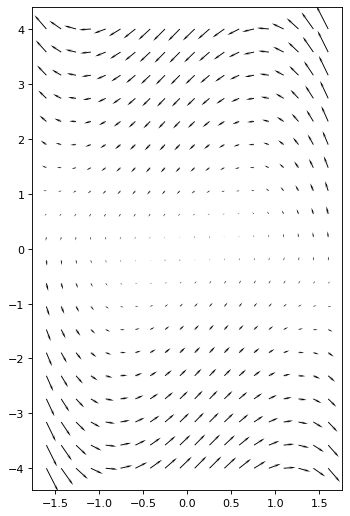

In [6]:
plt.figure(figsize=(5,8))
plt.quiver(X,Y, new_vf[0], new_vf[1], headwidth=3, headlength=8)
plt.show()

In [7]:
my_data = Create_Data(vf, dim)
tr, te, omega_domain, vfdata = my_data.create_raw_data(n, bounds, test_n)
tr = my_data.shuffle_and_batch_dataset(tr, batch_n, buff)
# te = my_data.shuffle_and_batch_dataset(te, batch_n)

2022-06-19 16:38:18.881302: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# g_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic()
# g_kernel.apply(x,y)

In [9]:
def A_i_j(x, y, K, g):    
    with tf.GradientTape() as tape:
        tape.watch(x)
        tape.watch(y)
        z = K.apply(x,y)
    dzdx, dzdy = tape.gradient(z, [x,y])
    vfx = tf.math.reduce_sum(dzdx*tf.transpose(tf.convert_to_tensor(g(x), dtype=tf.double)),axis=1)
    vfy = tf.math.reduce_sum(dzdy*tf.transpose(tf.convert_to_tensor(g(y), dtype=tf.double)),axis=1)

    product = tf.tensordot(vfx, vfy, axes=0)
    return product

In [30]:
# x = tf.constant([tf.linspace(-5, 6, 90), tf.linspace(-5, 6, 90)])
x = tf.constant(omega_domain)
y = tf.constant(omega_domain + 1)
# y = tf.constant([tf.linspace(-2, 4, 90), tf.linspace(-2, 4, 90)])
g_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic()
product =A_i_j(x,y,g_kernel, vf)

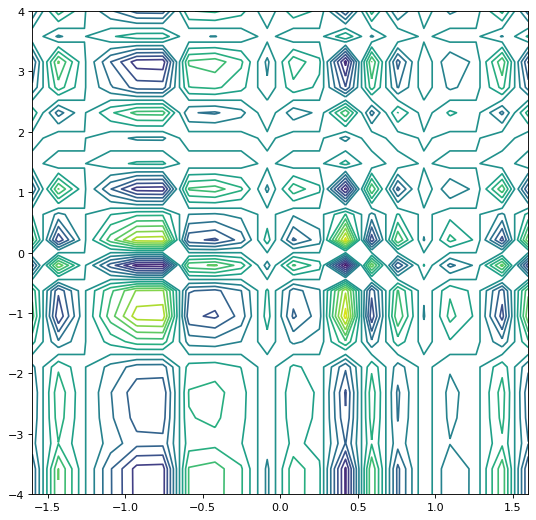

In [31]:
X =np.linspace(-bounds[0], bounds[0], 20)
Y = np.linspace(-bounds[1], bounds[1], 20)

cp = plt.contour(X,Y,product, levels=15)

In [32]:
beta = - tf.square(x)
alphas = tf.linalg.solve(product, beta)
alphas.shape

TensorShape([20, 2])